In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


[CinePOS Theaters]
  Shape: 4,690 rows | 5 cols
  Memory: 0.18 MB
   Missing Values: 7722


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017


--------------------------------------------------
[BookNow Theaters]
  Shape: 829 rows | 5 cols
  Memory: 0.03 MB
   Missing Values: 515


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017


--------------------------------------------------
[Theater Relation]
  Shape: 150 rows | 2 cols
  Memory: 0.00 MB
   Clean (no nulls)


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923


--------------------------------------------------
[CinePOS Booking]
  Shape: 1,641,966 rows | 4 cols
  Memory: 50.11 MB
   Clean (no nulls)


,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2


--------------------------------------------------
[BookNow Booking]
  Shape: 68,336 rows | 4 cols
  Memory: 2.09 MB
   Clean (no nulls)


,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6


--------------------------------------------------
[BookNow Visits]
  Shape: 214,046 rows | 3 cols
  Memory: 4.90 MB
   Clean (no nulls)


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58


--------------------------------------------------
[Date Info]
  Shape: 547 rows | 2 cols
  Memory: 0.01 MB
   Clean (no nulls)


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday


--------------------------------------------------
[Sample Submission]
  Shape: 38,062 rows | 2 cols
  Memory: 0.58 MB
   Clean (no nulls)


,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0


--------------------------------------------------


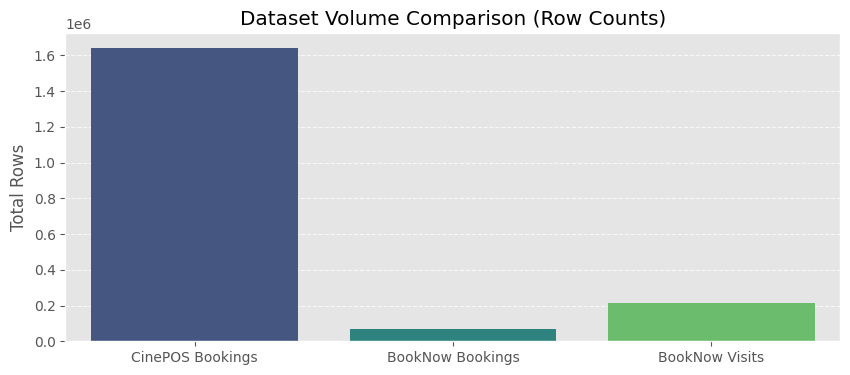


 All data loaded. EDA ready.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Keeping the output clean and setting preferences
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot') 

BASE_PATH = "/kaggle/input/Cinema_Audience_Forecasting_challenge"

# Quick utility to load and do a basic health check on the csvs
def load_and_inspect(folder_path, name, nrows=3):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    
    if not csv_files:
        raise FileNotFoundError(f"Wait, no CSV found in {folder_path}")
    
    csv_path = os.path.join(folder_path, csv_files[0])
    df = pd.read_csv(csv_path)
    
    # Printing some vital stats right away
    print(f"[{name}]")
    print(f"  Shape: {df.shape[0]:,} rows | {df.shape[1]} cols")
    print(f"  Memory: {df.memory_usage().sum() / 1024**2:.2f} MB") # Good to know for memory optimization later
    
    # Quick check for nulls
    missing = df.isnull().sum().sum()
    if missing > 0:
        print(f"   Missing Values: {missing}")
    else:
        print("   Clean (no nulls)")
        
    display(df.head(nrows))
    print("-" * 50)
    return df

# LOADING DATASETS


# 1. Theater Information
cinepos_theaters  = load_and_inspect(os.path.join(BASE_PATH, "cinePOS_theaters"), "CinePOS Theaters")
booknow_theaters  = load_and_inspect(os.path.join(BASE_PATH, "booknow_theaters"), "BookNow Theaters")
theater_relation  = load_and_inspect(os.path.join(BASE_PATH, "movie_theater_id_relation"), "Theater Relation")

# 2. Transactional Data (The heavy lifters)
cinepos_booking   = load_and_inspect(os.path.join(BASE_PATH, "cinePOS_booking"), "CinePOS Booking")
booknow_booking   = load_and_inspect(os.path.join(BASE_PATH, "booknow_booking"), "BookNow Booking")
booknow_visits    = load_and_inspect(os.path.join(BASE_PATH, "booknow_visits"), "BookNow Visits")

# 3. Meta & Submission
date_info         = load_and_inspect(os.path.join(BASE_PATH, "date_info"), "Date Info")
sample_submission = load_and_inspect(os.path.join(BASE_PATH, "sample_submission"), "Sample Submission")


# VISUAL SUMMARY

# Just want to see the scale difference between the booking sources
row_counts = {
    'CinePOS Bookings': len(cinepos_booking),
    'BookNow Bookings': len(booknow_booking),
    'BookNow Visits': len(booknow_visits)
}

plt.figure(figsize=(10, 4))
sns.barplot(x=list(row_counts.keys()), y=list(row_counts.values()), palette='viridis')
plt.title("Dataset Volume Comparison (Row Counts)")
plt.ylabel("Total Rows")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n All data loaded. EDA ready.")

 INITIAL DATA HEALTH CHECK

 CinePOS Theaters
   Shape: 4,690 rows | 5 columns
   No duplicates

  Columns with Holes:
           Missing Count  Missing %
latitude            3861      82.32
longitude           3861      82.32


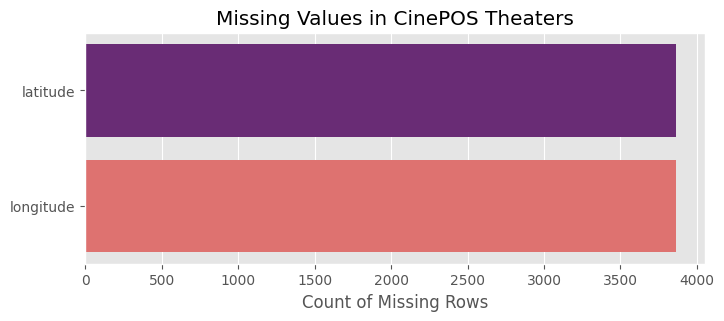


   Unique Value Snapshot (Top 5):
cine_theater_id    4690
theater_area        119
latitude            108
longitude           108
theater_type          3
dtype: int64

————————————————————————————————————————

 BookNow Theaters
   Shape: 829 rows | 5 columns
   Duplicates found: 354 (42.70%)

  Columns with Holes:
                 Missing Count  Missing %
book_theater_id            515      62.12


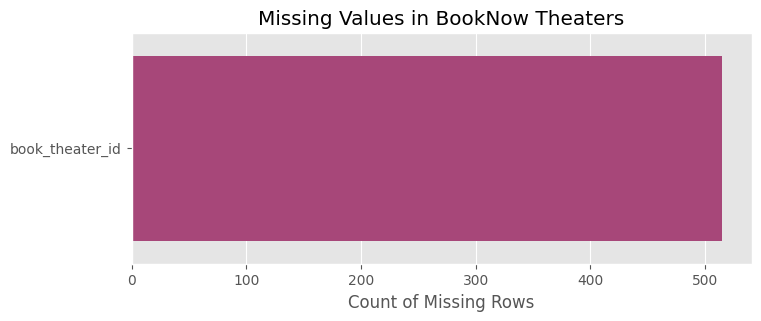


   Unique Value Snapshot (Top 5):
book_theater_id    314
latitude           108
longitude          108
theater_area       103
theater_type         4
dtype: int64

————————————————————————————————————————

 Theater Relation
   Shape: 150 rows | 2 columns
   No duplicates
    Clean (No missing values)

   Unique Value Snapshot (Top 5):
book_theater_id    150
cine_theater_id    150
dtype: int64

————————————————————————————————————————

 CinePOS Booking
   Shape: 1,641,966 rows | 4 columns
   Duplicates found: 12541 (0.76%)
    Clean (No missing values)

   Unique Value Snapshot (Top 5):
cine_theater_id     13161
booking_datetime    10152
show_datetime        8283
tickets_sold           97
dtype: int64

————————————————————————————————————————

 BookNow Booking
   Shape: 68,336 rows | 4 columns
   Duplicates found: 2042 (2.99%)
    Clean (No missing values)

   Unique Value Snapshot (Top 5):
booking_datetime    6351
show_datetime       3866
book_theater_id      301
tickets_booked        

In [3]:
# Grouping them to iterate cleanly
all_dfs = {
    "CinePOS Theaters": cinepos_theaters,
    "BookNow Theaters": booknow_theaters,
    "Theater Relation": theater_relation,
    "CinePOS Booking": cinepos_booking,
    "BookNow Booking": booknow_booking,
    "BookNow Visits": booknow_visits,
    "Date Info": date_info,
    "Sample Submission": sample_submission
}

print(" INITIAL DATA HEALTH CHECK\n")

for name, df in all_dfs.items():
    print(f" {name}")
    print(f"   Shape: {df.shape[0]:,} rows | {df.shape[1]} columns")
    
    # 1. Duplicate Check (Always good to check this early)
    dupes = df.duplicated().sum()
    if dupes > 0:
        print(f"   Duplicates found: {dupes} ({dupes/len(df):.2%})")
    else:
        print("   No duplicates")

    # 2. Null Value Analysis
    null_counts = df.isnull().sum()
    total_nulls = null_counts[null_counts > 0]
    
    if len(total_nulls) > 0:
        # Create a mini report for missing data
        missing_df = pd.DataFrame({
            'Missing Count': total_nulls,
            'Missing %': (total_nulls / len(df) * 100).round(2)
        }).sort_values('Missing %', ascending=False)
        
        print("\n  Columns with Holes:")
        print(missing_df)
        
        # Visualizing the gaps - easier to see the scale of missingness
        plt.figure(figsize=(8, 3))
        sns.barplot(x=total_nulls.values, y=total_nulls.index, palette='magma')
        plt.title(f"Missing Values in {name}")
        plt.xlabel("Count of Missing Rows")
        plt.show()
    else:
        print("    Clean (No missing values)")

    # 3. Unique Value check (Scanning for cardinality)
    # Just printing the top 5 high-cardinality columns to save space
    print(f"\n   Unique Value Snapshot (Top 5):")
    print(df.nunique().sort_values(ascending=False).head(5))
    
    print("\n" + "—"*40 + "\n")

##  STARTING DATA CLEANING PIPELINE

 STARTING DATA CLEANING PIPELINE

 Step 1: Handling missing IDs in BookNow Theaters...
   Original size: 829
   Dropped: 515 rows (62.12%)
   Final size: 314


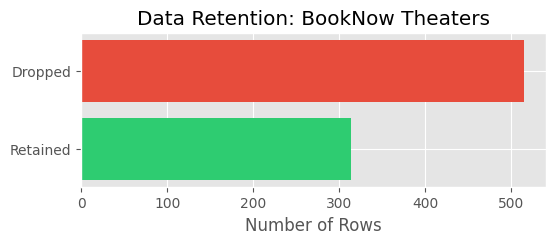

----------------------------------------


In [4]:
print(" STARTING DATA CLEANING PIPELINE\n")

# 1. CLEANING BOOKNOW THEATERS (Row Filtering)

print(" Step 1: Handling missing IDs in BookNow Theaters...")

booknow_theaters_cleaned = booknow_theaters.copy()
initial_rows = len(booknow_theaters_cleaned)

# Dropping rows where ID is null (can't map these anyway)
booknow_theaters_cleaned.dropna(subset=['book_theater_id'], inplace=True)
final_rows = len(booknow_theaters_cleaned)
removed_rows = initial_rows - final_rows

print(f"   Original size: {initial_rows}")
print(f"   Dropped: {removed_rows} rows ({(removed_rows/initial_rows)*100:.2f}%)")
print(f"   Final size: {final_rows}")

# Visualizing the impact of the drop
if removed_rows > 0:
    plt.figure(figsize=(6, 2))
    plt.barh(['Retained', 'Dropped'], [final_rows, removed_rows], color=['#2ecc71', '#e74c3c'])
    plt.title("Data Retention: BookNow Theaters")
    plt.xlabel("Number of Rows")
    plt.show()
else:
    print("    No rows dropped. Dataset was already clean on IDs.")

print("-" * 40)


 Step 2: pruning sparse columns in CinePOS Theaters...


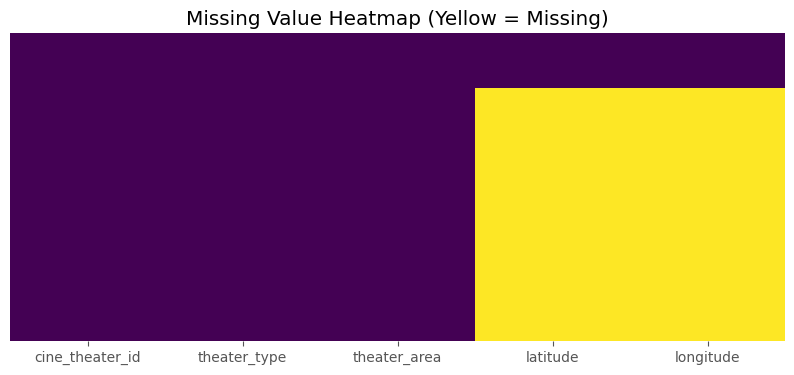

   Dropping columns: ['latitude', 'longitude'] due to high sparsity.
   Remaining columns: ['cine_theater_id', 'theater_type', 'theater_area']
----------------------------------------


In [5]:

# 2. CLEANING CINEPOS THEATERS (Column Filtering)

print("\n Step 2: pruning sparse columns in CinePOS Theaters...")

cinepos_theaters_cleaned = cinepos_theaters.copy()

# Visualizing WHY we are dropping these columns
# This heatmap shows yellow/light lines where data is missing. 
# If Lat/Long are mostly missing, this plot justifies the drop.
plt.figure(figsize=(10, 4))
sns.heatmap(cinepos_theaters.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Value Heatmap (Yellow = Missing)")
plt.show()

cols_to_drop = ['latitude', 'longitude']
print(f"   Dropping columns: {cols_to_drop} due to high sparsity.")

cinepos_theaters_cleaned.drop(columns=cols_to_drop, inplace=True)

print(f"   Remaining columns: {cinepos_theaters_cleaned.columns.tolist()}")

print("-" * 40)



In [6]:

# 3. STANDARDIZING REMAINDER
print("\n Step 3: Standardizing remaining datasets...")
# Creating clean copies for consistency so subsequent cells just use *_cleaned variables
theater_relation_cleaned = theater_relation.copy()
booknow_visits_cleaned   = booknow_visits.copy()
date_info_cleaned        = date_info.copy()
cinepos_booking_cleaned  = cinepos_booking.copy()
booknow_booking_cleaned  = booknow_booking.copy()

print(f"    Theater Relation copied ({len(theater_relation_cleaned)} rows)")
print(f"    BookNow Visits copied ({len(booknow_visits_cleaned)} rows)")
print(f"    Date Info copied ({len(date_info_cleaned)} rows)")
print(f"    Booking Data copied (CinePOS & BookNow)")

print("\n Cleaning phase complete. Ready for merging.")


 Step 3: Standardizing remaining datasets...
    Theater Relation copied (150 rows)
    BookNow Visits copied (214046 rows)
    Date Info copied (547 rows)
    Booking Data copied (CinePOS & BookNow)

 Cleaning phase complete. Ready for merging.


## MASTER MERGE PIPELINE

In [7]:
print(" INITIATING MASTER MERGE PIPELINE (Final Fix)\n")

# STEP 1: ESTABLISH BASE

master_df = booknow_visits_cleaned.copy()
print(f"⃣  Base DataFrame (Visits) loaded: {master_df.shape[0]:,} rows")


 INITIATING MASTER MERGE PIPELINE (Final Fix)

⃣  Base DataFrame (Visits) loaded: 214,046 rows


In [8]:
# ---------------------------------------------------------
# STEP 2: ENRICH WITH DATE METADATA
# ---------------------------------------------------------
print(" Merging Date Info...")
master_df = pd.merge(master_df, date_info_cleaned, on='show_date', how='left')

# Sanity Check for Dates
missing_dates = master_df['day_of_week'].isnull().sum()
if missing_dates > 0:
    print(f"     Warning: {missing_dates} rows failed to match a date!")
else:
    print(f"     Date mapping 100% successful.")


 Merging Date Info...
     Date mapping 100% successful.


  Merging Theater Info...
    Current Columns: ['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'theater_type', 'theater_area', 'latitude', 'longitude']

 MASTER DATAFRAME ASSEMBLED
Final Shape: 214,046 rows | 8 columns


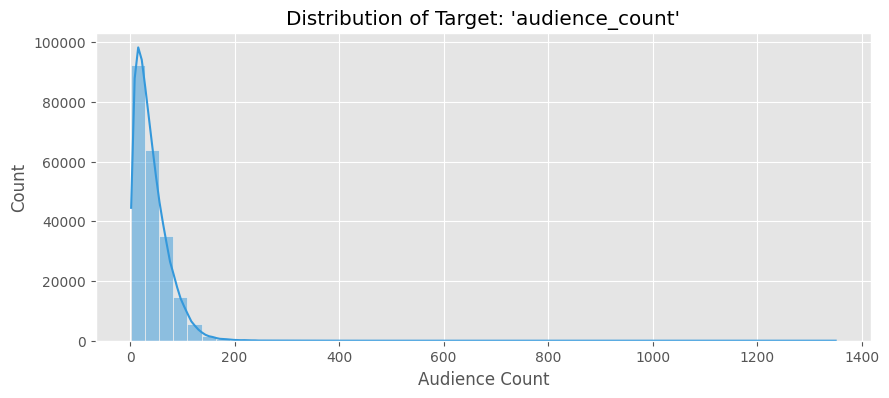


 Nulls detected (potential merge misses):
theater_type    133896
theater_area    133896
latitude        133896
longitude       133896
dtype: int64


,book_theater_id,show_date,audience_count,day_of_week,theater_type,theater_area,latitude,longitude
0,book_00001,2023-01-13,50,Friday,Drama,Area_002,23.00441,79.934515
1,book_00001,2023-01-14,64,Saturday,Drama,Area_002,23.00441,79.934515
2,book_00001,2023-01-15,58,Sunday,Drama,Area_002,23.00441,79.934515
3,book_00001,2023-01-16,44,Monday,Drama,Area_002,23.00441,79.934515
4,book_00001,2023-01-18,12,Wednesday,Drama,Area_002,23.00441,79.934515


In [9]:

# STEP 3: ENRICH WITH THEATER METADATA

print("  Merging Theater Info...")
master_df = pd.merge(master_df, booknow_theaters_cleaned, on='book_theater_id', how='left')

print(f"    Current Columns: {master_df.columns.tolist()}")


# POST-MERGE DIAGNOSTICS

print("\n" + "="*50)
print(" MASTER DATAFRAME ASSEMBLED")
print("="*50)

# 1. Structural Check
print(f"Final Shape: {master_df.shape[0]:,} rows | {master_df.shape[1]} columns")

# 2. Target Variable Analysis (Corrected to 'audience_count')
plt.figure(figsize=(10, 4))
sns.histplot(master_df['audience_count'], bins=50, kde=True, color='#3498db')
plt.title("Distribution of Target: 'audience_count'")
plt.xlabel("Audience Count")
plt.show()

# 3. Null Check Post-Merge
nulls_post_merge = master_df.isnull().sum()
cols_with_nulls = nulls_post_merge[nulls_post_merge > 0]

if not cols_with_nulls.empty:
    print("\n Nulls detected (potential merge misses):")
    print(cols_with_nulls.sort_values(ascending=False))
else:
    print("\n Dataset is dense (No Nulls detected).")

display(master_df.head())

 ## FEATURE ENGINEERING

In [10]:
print(" KICKING OFF FEATURE ENGINEERING\n")


# 1. HANDLING MISSING DATA (The Smart Way)

print(" Step 1: Flagging & Filling Missing Info...")

# Creating a flag so the model knows we improvised here
master_df['is_theater_info_missing'] = master_df['theater_type'].isnull().astype(int)

# Filling categorical gaps with a placeholder rather than dropping them
cols_to_fill = ['theater_type', 'theater_area']
master_df[cols_to_fill] = master_df[cols_to_fill].fillna('Unknown')

# Dropping lat/long as decided earlier (too sparse/noisy)
if 'latitude' in master_df.columns:
    master_df.drop(columns=['latitude', 'longitude'], inplace=True)

print(f"   Flag created. Missing count: {master_df['is_theater_info_missing'].sum()}")


 KICKING OFF FEATURE ENGINEERING

 Step 1: Flagging & Filling Missing Info...
   Flag created. Missing count: 133896


In [11]:
# 2. DATE FEATURE EXTRACTION

print("\n Step 2: Exploding 'show_date' into useful components...")

master_df['show_date'] = pd.to_datetime(master_df['show_date'])

# Extracting temporal patterns
master_df['year'] = master_df['show_date'].dt.year
master_df['month'] = master_df['show_date'].dt.month
master_df['day'] = master_df['show_date'].dt.day
master_df['week_of_year'] = master_df['show_date'].dt.isocalendar().week.astype(int)

# Weekend flag (0=Weekday, 1=Weekend)
master_df['is_weekend'] = (master_df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)

print("    Extracted: Year, Month, Day, Week, Is_Weekend")



 Step 2: Exploding 'show_date' into useful components...
    Extracted: Year, Month, Day, Week, Is_Weekend



 Step 3: Aggregating Online Booking Behavior...


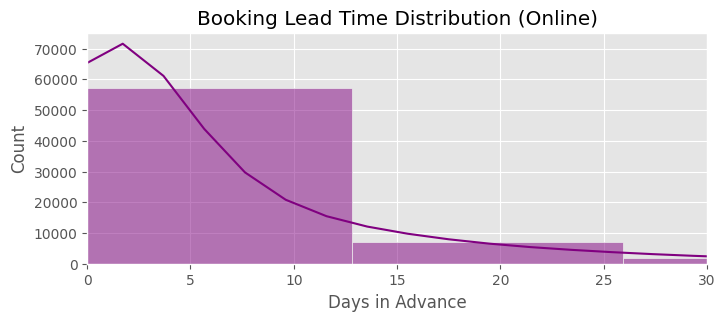

    Online features merged.


In [12]:

# 3. ONLINE BOOKING SIGNALS (BookNow)

print("\n Step 3: Aggregating Online Booking Behavior...")

book_bookings = booknow_booking_cleaned.copy()

# Converting string dates to datetime objects
book_bookings['show_datetime'] = pd.to_datetime(book_bookings['show_datetime'])
book_bookings['booking_datetime'] = pd.to_datetime(book_bookings['booking_datetime'])
book_bookings['show_date'] = pd.to_datetime(book_bookings['show_datetime'].dt.date)

# Feature: Lead Time (How many days in advance did they book?)
book_bookings['booking_lead_days'] = (book_bookings['show_datetime'] - book_bookings['booking_datetime']).dt.total_seconds() / (24 * 60 * 60)

# Visualizing Lead Time (Is it mostly last minute?)
plt.figure(figsize=(8, 3))
sns.histplot(book_bookings['booking_lead_days'], bins=30, color='purple', kde=True)
plt.title("Booking Lead Time Distribution (Online)")
plt.xlabel("Days in Advance")
plt.xlim(0, 30) # Zooming in on the first month
plt.show()

# Aggregating by Theater + Date
online_features = book_bookings.groupby(['book_theater_id', 'show_date']).agg(
    total_online_tickets=('tickets_booked', 'sum'),
    avg_online_lead_days=('booking_lead_days', 'mean')
).reset_index()

# Merging back to master
master_df = pd.merge(master_df, online_features, on=['book_theater_id', 'show_date'], how='left')
print("    Online features merged.")


In [13]:

# 4. OFFLINE/POS BOOKING SIGNALS (CinePOS)

print("\n Step 4: Aggregating Walk-in/POS Behavior...")

pos_bookings = cinepos_booking_cleaned.copy()

# We need to bridge CinePOS IDs to BookNow IDs using the relation table
pos_bookings_linked = pd.merge(pos_bookings, theater_relation_cleaned, on='cine_theater_id', how='inner')

pos_bookings_linked['show_datetime'] = pd.to_datetime(pos_bookings_linked['show_datetime'])
pos_bookings_linked['show_date'] = pd.to_datetime(pos_bookings_linked['show_datetime'].dt.date)

# Aggregating tickets sold
pos_features = pos_bookings_linked.groupby(['book_theater_id', 'show_date']).agg(
    total_pos_tickets=('tickets_sold', 'sum')
).reset_index()

# Merging back to master
master_df = pd.merge(master_df, pos_features, on=['book_theater_id', 'show_date'], how='left')
print("    POS features merged.")



 Step 4: Aggregating Walk-in/POS Behavior...
    POS features merged.



 Step 5: Final Polish...
   Dropped raw 'show_date' column.
--------------------------------------------------
 FEATURE ENGINEERING COMPLETE
--------------------------------------------------


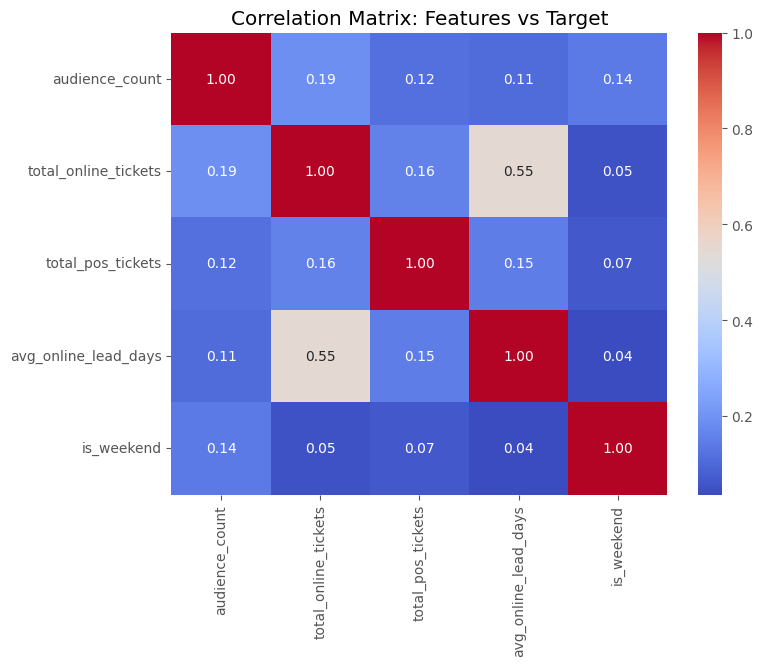

,book_theater_id,audience_count,day_of_week,theater_type,theater_area,is_theater_info_missing,year,month,day,week_of_year,is_weekend,total_online_tickets,avg_online_lead_days,total_pos_tickets
0,book_00001,50,Friday,Drama,Area_002,0,2023,1,13,2,0,0.0,0.0,0.0
1,book_00001,64,Saturday,Drama,Area_002,0,2023,1,14,2,1,0.0,0.0,0.0
2,book_00001,58,Sunday,Drama,Area_002,0,2023,1,15,2,1,0.0,0.0,0.0
3,book_00001,44,Monday,Drama,Area_002,0,2023,1,16,3,0,0.0,0.0,0.0
4,book_00001,12,Wednesday,Drama,Area_002,0,2023,1,18,3,0,0.0,0.0,0.0
5,book_00001,18,Thursday,Drama,Area_002,0,2023,1,19,3,0,0.0,0.0,0.0
6,book_00001,62,Friday,Drama,Area_002,0,2023,1,20,3,0,0.0,0.0,0.0
7,book_00001,42,Saturday,Drama,Area_002,0,2023,1,21,3,1,0.0,0.0,0.0
8,book_00001,36,Sunday,Drama,Area_002,0,2023,1,22,3,1,0.0,0.0,0.0
9,book_00001,52,Monday,Drama,Area_002,0,2023,1,23,4,0,0.0,0.0,0.0


In [14]:
# 5. CLEANUP & FINAL TOUCHES

print("\n Step 5: Final Polish...")

# Fill NaNs for days with 0 sales (Merge creates NaNs if no match found)
fill_zeros = ['total_online_tickets', 'avg_online_lead_days', 'total_pos_tickets']
master_df[fill_zeros] = master_df[fill_zeros].fillna(0)

# Now that we extracted everything, we can drop the original date object
if 'show_date' in master_df.columns:
    master_df.drop(columns=['show_date'], inplace=True)
    print("   Dropped raw 'show_date' column.")

print("-" * 50)
print(" FEATURE ENGINEERING COMPLETE")
print("-" * 50)

# Quick Correlation Check: Do our new features matter?
# We select only numeric columns for the correlation matrix
numeric_cols = ['audience_count', 'total_online_tickets', 'total_pos_tickets', 'avg_online_lead_days', 'is_weekend']
corr_matrix = master_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Features vs Target")
plt.show()

display(master_df.head(10))

## MODEL TRANING 

### LIGHTGBM+ XGBOOST ENSEMBLE

In [15]:
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.metrics import r2_score

# print("--- EXPERIMENT: LightGBM + XGBoost Ensemble (using Advanced Features) ---")

# # Note: This block assumes 'X_train', 'y_train', 'X_val', 'y_val', etc.
# # have already been created by the 'Advanced Pipeline' cell above.

# # 1. Define Models
# # Using robust parameters adapted for this dataset
# lgb_model = lgb.LGBMRegressor(
#     objective='regression',
#     n_estimators=3000,
#     learning_rate=0.02,
#     num_leaves=32,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )

# xgb_model = xgb.XGBRegressor(
#     objective='reg:absoluteerror',
#     n_estimators=2000,
#     learning_rate=0.02,
#     max_depth=8,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )

# # 2. Train on the Split Data (to check validation score)
# print(" Training LightGBM...")
# lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
#               eval_metric='rmse',
#               callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])

# print(" Training XGBoost...")
# xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
#               early_stopping_rounds=100, verbose=False)

# # 3. Validate and Blend
# p1_val = lgb_model.predict(X_val)
# p2_val = xgb_model.predict(X_val)

# # Simple Average Ensemble (50% weight to each)
# p_ensemble_val = (p1_val * 0.5) + (p2_val * 0.5)

# val_r2_lgb = r2_score(y_val, p1_val)
# val_r2_xgb = r2_score(y_val, p2_val)
# val_r2_ens = r2_score(y_val, p_ensemble_val)

# print(f"\n Validation Scores (R2):")
# print(f"   LightGBM: {val_r2_lgb:.4f}")
# print(f"   XGBoost:  {val_r2_xgb:.4f}")
# print(f"   Ensemble: {val_r2_ens:.4f} (Blended Score)")

# # 4. Retrain on Full Data & Generate Submission
# print("\n Retraining Ensemble on Full Data...")

# # Fitting on X_full_train / y_full_train defined in previous cells
# lgb_model.fit(X_full_train, y_full_train)
# xgb_model.fit(X_full_train, y_full_train)

# # Predict on Test
# p1_test = lgb_model.predict(X_test)
# p2_test = xgb_model.predict(X_test)

# final_predictions_ensemble = (p1_test * 0.5) + (p2_test * 0.5)

# # Post-processing (Clipping negatives and rounding)
# final_predictions_ensemble = np.maximum(final_predictions_ensemble, 0)
# final_predictions_ensemble = np.round(final_predictions_ensemble).astype(int)

# # Create Ensemble Submission File
# # reusing 'test_features' from your pipeline which contains the IDs
# submission_ensemble = test_features[['ID']].copy()
# submission_ensemble['audience_count'] = final_predictions_ensemble

# # submission_ensemble.to_csv('submission_ensemble.csv', index=False)
# print(" Ensemble submission dataframe created successfully.")
# display(submission_ensemble.head())

## DIFFERENT MODEL EVALUATION

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score # r2_score import karein
import numpy as np

# Tree-based models
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# --- Puraane Steps se DataFrames Load Karein ---
# Maan lein ki saare zaroori DataFrames pehle se loaded hain.

print("--- Model Training, Comparison (using R-squared), and Final Submission ---")

# --- Step 1: Data Preparation for Training ---
print("\nStep 1: Preparing training data...")
train_val_df = master_df.copy()
categorical_cols = train_val_df.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_val_df[col] = le.fit_transform(train_val_df[col])
    encoders[col] = le
print(f"Label Encoded columns: {categorical_cols}")

# --- Step 2: Create Training and Validation Sets ---
print("\nStep 2: Splitting data into train and validation sets...")
train_val_df['temp_date'] = pd.to_datetime(train_val_df[['year', 'month', 'day']])
train_df = train_val_df[train_val_df['temp_date'] < '2024-02-01']
val_df = train_val_df[train_val_df['temp_date'] >= '2024-02-01']
train_df = train_df.drop(columns=['temp_date'])
val_df = val_df.drop(columns=['temp_date'])
features = [col for col in train_df.columns if col not in ['audience_count']]
X_train = train_df[features]
y_train = train_df['audience_count']
X_val = val_df[features]
y_val = val_df['audience_count']
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- Step 3 & 4: Build and Engineer Features for Test Set ---
print("\nStep 3 & 4: Building and engineering features for the test set...")
test_df = sample_submission.copy()
test_df['book_theater_id'] = test_df['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test_df['show_date'] = pd.to_datetime(test_df['ID'].apply(lambda x: x.split('_')[2]))
test_df.drop(columns=['audience_count'], inplace=True)
date_info_cleaned['show_date'] = pd.to_datetime(date_info_cleaned['show_date'])
test_df = pd.merge(test_df, date_info_cleaned, on='show_date', how='left')
test_df['year'] = test_df['show_date'].dt.year
test_df['month'] = test_df['show_date'].dt.month
test_df['day'] = test_df['show_date'].dt.day
test_df['week_of_year'] = test_df['show_date'].dt.isocalendar().week.astype(int)
test_df['is_weekend'] = (test_df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
test_df = pd.merge(test_df, booknow_theaters_cleaned, on='book_theater_id', how='left')
test_df['is_theater_info_missing'] = test_df['theater_type'].isnull().astype(int)
test_df['theater_type'] = test_df['theater_type'].fillna('Unknown')
test_df['theater_area'] = test_df['theater_area'].fillna('Unknown')
online_features['show_date'] = pd.to_datetime(online_features['show_date'])
pos_features['show_date'] = pd.to_datetime(pos_features['show_date'])
test_df = pd.merge(test_df, online_features, on=['book_theater_id', 'show_date'], how='left')
test_df = pd.merge(test_df, pos_features, on=['book_theater_id', 'show_date'], how='left')
test_df[['total_online_tickets', 'avg_online_lead_days', 'total_pos_tickets']] = test_df[['total_online_tickets', 'avg_online_lead_days', 'total_pos_tickets']].fillna(0)
for col, le in encoders.items():
    test_df[col] = test_df[col].map(lambda s: str(s) if s not in le.classes_ else s)
    new_labels = set(test_df[col]) - set(le.classes_)
    if new_labels:
        le.classes_ = np.append(le.classes_, sorted(list(new_labels)))
    test_df[col] = le.transform(test_df[col])
X_test = test_df[features]
print(f"Test data shape: {X_test.shape}")

# --- Step 5: Train and Evaluate Models using R-squared ---
print("\nStep 5: Training and evaluating models (Objective: Maximize R-squared)...")
models = {
    "LightGBM": lgb.LGBMRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100)
}
results_r2 = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    # NEW: R2 score calculated
    score = r2_score(y_val, predictions)
    results_r2[name] = score
    print(f"{name} Validation R-squared: {score:.4f}")

# --- Step 6: Choose the Best Model based on R-squared ---
# BADLAV: Ab sabse zyada R2 score wala model chunein
best_model_name = max(results_r2, key=results_r2.get)
print(f"\nStep 6: Best model is {best_model_name} with R-squared: {results_r2[best_model_name]:.4f}")

# --- Step 7: Retrain and Predict ---
print(f"\nStep 7: Retraining {best_model_name} and creating submission file...")
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])
best_model = models[best_model_name]
best_model.fit(X_full_train, y_full_train)
final_predictions = best_model.predict(X_test)
final_predictions[final_predictions < 0] = 0
final_predictions = np.round(final_predictions).astype(int)
submission_df = test_df[['ID']].copy()
submission_df['audience_count'] = final_predictions
# submission_df.to_csv('submission.csv', index=False)

# print("\n 'submission.csv' file has been successfully created!")
# display(submission_df.head())

--- Model Training, Comparison (using R-squared), and Final Submission ---

Step 1: Preparing training data...
Label Encoded columns: ['book_theater_id', 'day_of_week', 'theater_type', 'theater_area']

Step 2: Splitting data into train and validation sets...
Training data shape: (194235, 13)
Validation data shape: (19811, 13)

Step 3 & 4: Building and engineering features for the test set...
Test data shape: (38062, 13)

Step 5: Training and evaluating models (Objective: Maximize R-squared)...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 194235, number of used features: 13
[LightGBM] [Info] Start training from score 41.727474
LightGBM Validation R-squared: 0.3031
Training XGBoost...
XGBoost Validat

In [17]:
# from sklearn.model_selection import RandomizedSearchCV

# print("---  Hyperparameter Tuning (Randomized Search) ---")

# # 1. Define the parameter grid to search
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # 2. Initialize the base model
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# # 3. Setup RandomizedSearchCV
# # n_iter=10 limits it to 10 random combinations to save time (vs. trying all 100+)
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=10, 
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1,
#     scoring='r2'
# )

# # 4. Fit on the training data (from the previous block)
# print(" Tuning Random Forest parameters...")
# random_search.fit(X_train, y_train)

# # 5. Output results
# print(f" Best Parameters Found: {random_search.best_params_}")
# print(f" Best Cross-Validation R2: {random_search.best_score_:.4f}")


## traning random forest

 INITIATING ADVANCED PIPELINE: LAGS, ROLLING MEANS & RANDOM FOREST

 Step 1: Injecting Time-Series Signals (Lags & Rolling Means)...
    Features added. Data Shape: (214046, 20)


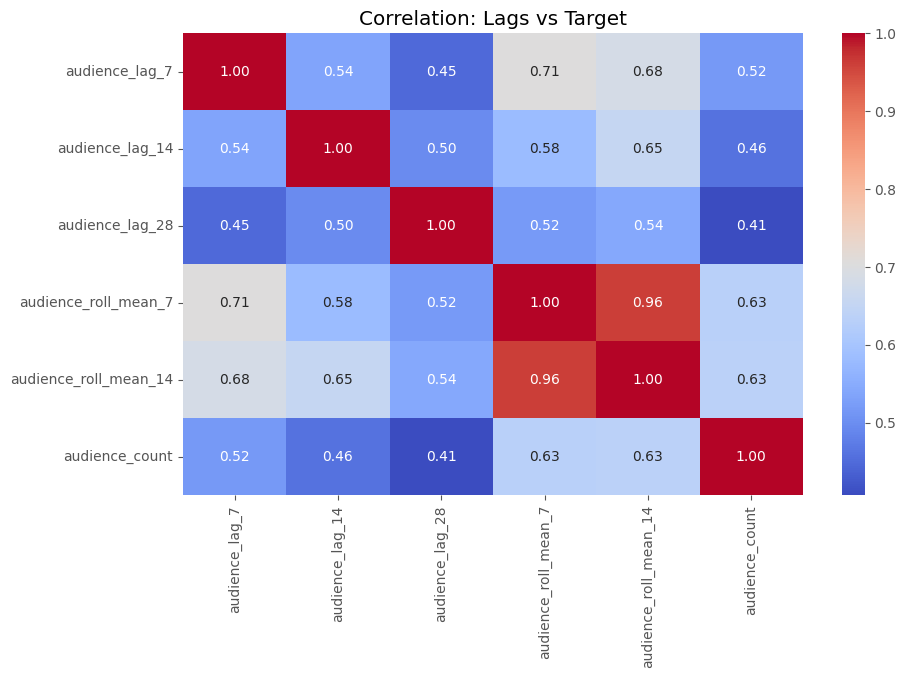


 Step 2: Slicing the data for validation...
   Train Range: 2023-01-01 -> 2023-12-27
   Val Range:   2023-12-28 -> 2024-02-28

 Step 3: Engineering the Test Set (Propagating History)...
   Applying historical lags to test set...
   Test Data Ready. Shape: (38062, 18)

 Step 4: Training Random Forest (w/ Lags)...
    Validation R-Squared: 0.4841


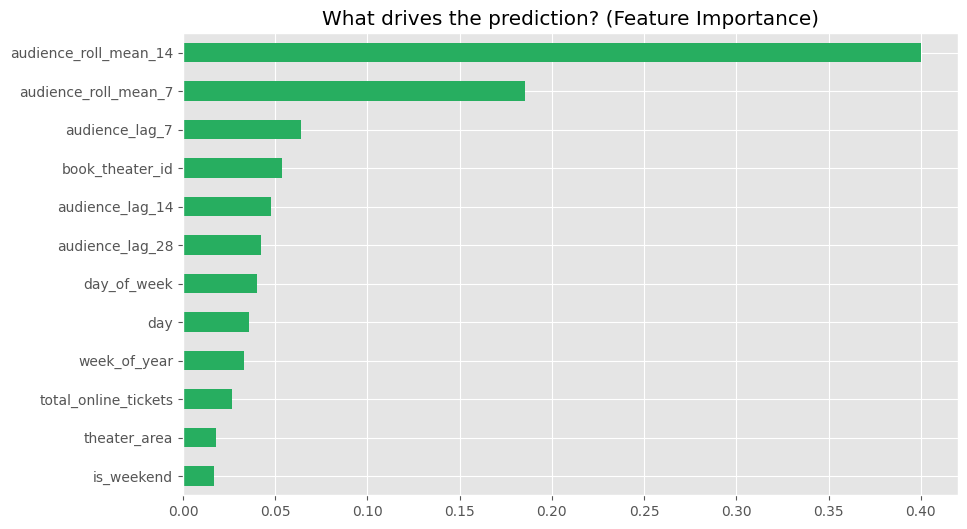


 Step 5: Retraining on Full Data & Generating Submission...


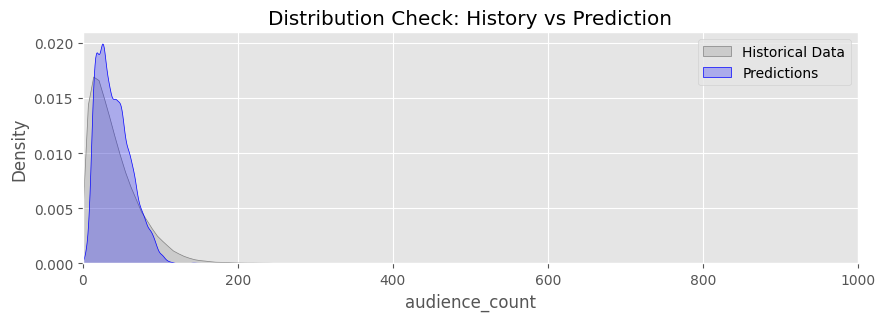


 DONE. 'submission.csv' is ready.


,ID,audience_count
0,book_00001_2024-03-01,37
1,book_00001_2024-03-02,45
2,book_00001_2024-03-03,61
3,book_00001_2024-03-04,39
4,book_00001_2024-03-06,29


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the visual vibe
plt.style.use('ggplot')

print(" INITIATING ADVANCED PIPELINE: LAGS, ROLLING MEANS & RANDOM FOREST\n")

# ---------------------------------------------------------
# 1. HELPER FUNCTION
# ---------------------------------------------------------
# A clean utility to regenerate basic features whenever needed
def create_basic_features(df, date_info, theater_info):
    df_copy = df.copy()
    
    # Ensure date is datetime
    if 'show_date' not in df_copy.columns and 'ID' in df_copy.columns:
         # Extract from ID if missing
         df_copy['show_date'] = pd.to_datetime(df_copy['ID'].apply(lambda x: x.split('_')[2]))
    else:
        df_copy['show_date'] = pd.to_datetime(df_copy['show_date'])

    # Merge metadata
    df_copy = pd.merge(df_copy, date_info, on='show_date', how='left')
    df_copy = pd.merge(df_copy, theater_info, on='book_theater_id', how='left')
    
    # Extract components
    df_copy['year'] = df_copy['show_date'].dt.year
    df_copy['month'] = df_copy['show_date'].dt.month
    df_copy['day'] = df_copy['show_date'].dt.day
    df_copy['week_of_year'] = df_copy['show_date'].dt.isocalendar().week.astype(int)
    df_copy['is_weekend'] = (df_copy['show_date'].dt.dayofweek >= 5).astype(int)
    
    # Handle Nulls
    df_copy['is_theater_info_missing'] = df_copy['theater_type'].isnull().astype(int)
    df_copy['theater_type'] = df_copy['theater_type'].fillna('Unknown')
    df_copy['theater_area'] = df_copy['theater_area'].fillna('Unknown')
    
    return df_copy

# ---------------------------------------------------------
# 2. FEATURE ENGINEERING (The "Secret Sauce")
# ---------------------------------------------------------
print(" Step 1: Injecting Time-Series Signals (Lags & Rolling Means)...")

full_df = master_df.copy()

# Reconstructing date object just to be safe
full_df['show_date'] = pd.to_datetime(full_df[['year', 'month', 'day']])

# SORTING is critical before calculating shifts!
full_df = full_df.sort_values(by=['book_theater_id', 'show_date']).reset_index(drop=True)

# 1. Lag Features (What happened 1 week, 2 weeks, 4 weeks ago?)
lags = [7, 14, 28]
for lag in lags:
    full_df[f'audience_lag_{lag}'] = full_df.groupby('book_theater_id')['audience_count'].shift(lag)

# 2. Rolling Features (What was the average trend over the last week/2 weeks?)
windows = [7, 14]
for w in windows:
    # shift(1) ensures we don't leak today's data into the mean
    full_df[f'audience_roll_mean_{w}'] = full_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window=w, min_periods=1).mean()

# Fill NaNs generated by shifting (first few weeks will be empty)
full_df.fillna(0, inplace=True)

print(f"    Features added. Data Shape: {full_df.shape}")

# VISUAL CHECK: Do these new features actually correlate?
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation to avoid errors
numeric_df = full_df.select_dtypes(include=[np.number])
new_features_check = [f'audience_lag_{l}' for l in lags] + [f'audience_roll_mean_{w}' for w in windows] + ['audience_count']
# Filter out any that might not be in numeric_df (just safety)
valid_feats = [f for f in new_features_check if f in numeric_df.columns]

sns.heatmap(numeric_df[valid_feats].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Lags vs Target")
plt.show()

# ---------------------------------------------------------
# 3. SPLITTING DATA (Time-Based)
# ---------------------------------------------------------
print("\n Step 2: Slicing the data for validation...")

last_date = full_df['show_date'].max()
validation_start_date = last_date - pd.DateOffset(months=2)

train_df = full_df[full_df['show_date'] < validation_start_date]
val_df = full_df[full_df['show_date'] >= validation_start_date]

print(f"   Train Range: {train_df['show_date'].min().date()} -> {train_df['show_date'].max().date()}")
print(f"   Val Range:   {val_df['show_date'].min().date()} -> {val_df['show_date'].max().date()}")

# Cleanup
train_df = train_df.drop(columns=['show_date'])
val_df = val_df.drop(columns=['show_date'])

# Encoding
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    
    # Handle unseen labels in validation
    val_df[col] = val_df[col].map(lambda s: s if s in le.classes_ else 'Unknown')
    # If 'Unknown' wasn't in train, we need to add it to classes
    if 'Unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Unknown')
        
    val_df[col] = le.transform(val_df[col].astype(str))
    encoders[col] = le

features = [col for col in train_df.columns if col not in ['audience_count']]
X_train = train_df[features]
y_train = train_df['audience_count']
X_val   = val_df[features]
y_val   = val_df['audience_count']

# Full training set for later
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

# ---------------------------------------------------------
# 4. PREPARING TEST SET
# ---------------------------------------------------------
print("\n Step 3: Engineering the Test Set (Propagating History)...")

test_df = sample_submission[['ID']].copy()
test_df['book_theater_id'] = test_df['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test_df['show_date'] = pd.to_datetime(test_df['ID'].apply(lambda x: x.split('_')[2]))

# 1. Basic Features
test_features = create_basic_features(test_df, date_info_cleaned, booknow_theaters_cleaned)

# 2. Merge External Booking Data
test_features = test_features.merge(online_features, on=['book_theater_id', 'show_date'], how='left')
test_features = test_features.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')

# 3. Add Lags/Rolling (Using the LAST known values from training)
# Note: This assumes the test patterns resemble the end of the training period.
print("   Applying historical lags to test set...")

for lag in lags:
    # Grab the very last value available for each theater
    last_values = full_df.groupby('book_theater_id')[f'audience_lag_{lag}'].last().rename(f'audience_lag_{lag}')
    test_features = test_features.merge(last_values, on='book_theater_id', how='left')

for w in windows:
    last_values = full_df.groupby('book_theater_id')[f'audience_roll_mean_{w}'].last().rename(f'audience_roll_mean_{w}')
    test_features = test_features.merge(last_values, on='book_theater_id', how='left')

test_features.fillna(0, inplace=True)

# 4. Encoding Test Set
for col, le in encoders.items():
    test_features[col] = test_features[col].astype(str)
    # Handle unseen labels
    test_features[col] = test_features[col].map(lambda s: s if s in le.classes_ else 'Unknown')
    test_features[col] = le.transform(test_features[col])

X_test = test_features[features]
print(f"   Test Data Ready. Shape: {X_test.shape}")

# ---------------------------------------------------------
# 5. TRAINING (RANDOM FOREST)
# ---------------------------------------------------------
print("\n Step 4: Training Random Forest (w/ Lags)...")
# Using a robust depth to prevent overfitting, but enough trees to generalize
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=20)

model.fit(X_train, y_train)
val_predictions = model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)

print(f"    Validation R-Squared: {val_r2:.4f}")

# VISUAL: Feature Importance
# This will tell us if our Lag Engineering was worth it
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(12).plot(kind='barh', color='#27ae60')
plt.title("What drives the prediction? (Feature Importance)")
plt.gca().invert_yaxis()
plt.show()

# ---------------------------------------------------------
# 6. FINAL SUBMISSION
# ---------------------------------------------------------
print("\n Step 5: Retraining on Full Data & Generating Submission...")

model.fit(X_full_train, y_full_train)
final_predictions = model.predict(X_test)

# Post-processing
final_predictions[final_predictions < 0] = 0
final_predictions = np.round(final_predictions).astype(int)

submission_df = test_features[['ID']].copy()
submission_df['audience_count'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

# Sanity Check Plot
plt.figure(figsize=(10, 3))
sns.kdeplot(y_full_train, label='Historical Data', fill=True, color='grey')
sns.kdeplot(final_predictions, label='Predictions', fill=True, color='blue')
plt.title("Distribution Check: History vs Prediction")
plt.xlim(0, 1000)
plt.legend()
plt.show()

print("\n DONE. 'submission.csv' is ready.")
display(submission_df.head())